# Preparation

## Library installation/import

Install and import libraries that are used in multiple sections of the pipeline.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
!pip install spacy==3.0
!pip install tweepy
!pip install wordcloud

In [15]:
!pip install spacy-transformers
!python -m spacy download en_core_web_trf

2021-04-01 16:29:38.055275: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


## Configuring Twitter API keys

Please note that the API keys below are the course leader's own API keys. You are allowed to use it to do some small tests, but please be careful because all students in the class now have a copy of it, and hence the limits can be easily exceeded.

If your group has decided to use Twitter data, you can [apply for your own keys](https://developer.twitter.com/en/apply-for-access).

In [16]:
import tweepy

auth = tweepy.OAuthHandler('fjkruboMzTLE4BLE7FmEpkWpw', 'jDobYz45Ksc3uMHoD2QnyZK60NwfRZnWIDVmyPtUGLkiOUqfGl')
auth.set_access_token('1374773661861830658-lPZKU2qeuepRxVfWs5OxRoZd6XGzrH', '84k6xIDIMrt5mzPFLCoesD0WM9bpk8d3bAKaNonbcuT0s')

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

## Downloading of new data set

**IMPORTANT NOTE**: Please do not run the cell below unless intending to download a new data set.

Make sure that you change the parameters.

Also, check the [Tweepy API reference](https://docs.tweepy.org/en/latest/api.html) to find out about other ways through which you can retrieve tweets, e.g., by specifying usernames.

In [17]:
# Collect tweets
query = "remote work" + " -filter:retweets"
cutoff_date = "2021-01-01"
tweets = tweepy.Cursor(api.search, q=query, lang="en", result_type='mixed').items(1000)

tweets_list = [[tweet.id, tweet.created_at, tweet.user.screen_name, tweet.user.location, tweet.text] for tweet in tweets]

tweets_df = pd.DataFrame(data=tweets_list, columns=['id', 'date', 'user', 'location', 'text'])

# A good idea to save downloaded tweets as CSV
tweets_df.to_csv ('current_set.csv', quotechar='"', encoding='utf8', index = False, header=True)

In [18]:
# function to collect tweets by ketword querying
def tweet_collector(query_key: str, filename: str, result_type='mixed', maxNoTweets=1000):
  query = query_key + " -filter:retweets"
  # support for cutoff_date removed in tweepy 3.8 idk why they still have it here
  # cutoff_date = "2021-01-01"
  tweets = tweepy.Cursor(api.search, q=query, lang="en", result_type=result_type).items(maxNoTweets)

  tweets_list = [[tweet.id, tweet.created_at, tweet.user.screen_name, tweet.user.location, tweet.text] for tweet in tweets]

  tweets_df = pd.DataFrame(data=tweets_list, columns=['id', 'date', 'user', 'location', 'text'])

  # A good idea to save downloaded tweets as CSV
  tweets_df.to_csv (f'{filename}.csv', quotechar='"', encoding='utf8', index = False, header=True)

In [19]:
# these queries have already been made, no point querying using these keywords
# again

# tweet_collector(query='remote work', filename='tweets_remote/current_set')
# tweet_collector(query='work from home', filename='tweets_remote/current_set_B')
# tweet_collector(query='#wfh', filename='tweets_remote/current_set_C')
# tweet_collector(query='#workfromhome', filename='tweets_remote/current_set_D')
# tweet_collector(query='remote work from home lifestyle', filename='tweets_remote/current_set_E')
# tweet_collector(query='#workingfromhome', filename='tweets_remote/current_set_F')



# for answering questions about which platform people use

# tweet_collector(query_key='zoom home', filename='tweets_platform/current_set_zoom_home')
# tweet_collector(query_key='microsoft home', filename='tweets_platform/current_set_ms_home')
# tweet_collector(query_key='slack home', filename='tweets_platform/current_set_slack_home')
# tweet_collector(query_key='discord work home', filename='tweets_platform/current_set_discord')
# tweet_collector(query_key='discord remote', filename='tweets_platform/current_set_discord_home')

In [20]:
# after creating a new set of tweets/csv file add the filename here
all_filenames_remote = [
  'current_set', 
  'current_set_B', 
  'current_set_C', 
  'current_set_D', 
  'current_set_E', 
  'current_set_F'
]

all_filenames_platform = [
  'current_set_zoom_home',
  'current_set_ms_home',
  'current_set_slack_home',
  'current_set_discord_home',
  'current_set_zoom',
  'current_set_ms',
  'current_set_slack',
  'current_set_discord'
]

# Data pre-processing

## Cleaning

Below we provide some code for text cleaning. However, we encourage you to think of other ways to clean your data, e.g., by removing hashtags, removing usernames, removing duplicate tweets?

In [21]:
#installing tweet-preprocessor
!pip install tweet-preprocessor
!pip install wordsegment
import preprocessor as p
from wordsegment import load, segment
import re

In [22]:
# combine the individual csv files

#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f'tweets_remote/{fname}.csv') for fname in all_filenames_remote])
#export to csv
combined_csv.to_csv("combined_remote.csv", index=False, encoding='utf8')

#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f'tweets_platform/{fname}.csv') for fname in all_filenames_platform])
#export to csv
combined_csv.to_csv("combined_platform.csv", index=False, encoding='utf8')

In [23]:
# comment if not using pre saved data set 
tweets_df = pd.read_csv('combined_remote.csv', quotechar='"', encoding='utf8')
cleaned_tweets = []

# include hastags and remove urls and emojis and mentions
#p.set_options(p.OPT.URL, p.OPT.EMOJI,p.OPT.MENTION)
for tweet in tweets_df['text']:
    cleaned_tweets.append(p.clean(tweet))

# adding back to data frame
tweets_df['text_processed'] = cleaned_tweets

#removing punctuation
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[,\\.!?]', '', x))

# Remove unnecessary line breaks
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r"\n", '', x))

# Convert the titles to lowercase
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: x.lower())

#removing hastags for now 
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r"#(\w+)","",x))

#removing extra whitespaces 
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: ' '.join(x.split()))

display(tweets_df)

,id,date,user,location,text,text_processed
0,1376530789177905153,2021-03-29 13:44:49,IngrahamAngle,DC,Now do Florida. Then ask yourselves who handl...,now do florida then ask yourselves who handled...
1,1376542205754621952,2021-03-29 14:30:11,nytimes,New York City,The coronavirus prompted a tectonic shift in h...,the coronavirus prompted a tectonic shift in h...
2,1376164425405710338,2021-03-28 13:29:01,ASCD,"Alexandria, VA (D.C. area)",Feedback’s main purpose is to improve the stud...,feedbacks main purpose is to improve the stude...
3,1376713727190392838,2021-03-30 01:51:45,Sally_bak_,"Ohio, USA",@thoughtwax Remote work provides new access to...,remote work provides new access to talent wher...
4,1376713711851831301,2021-03-30 01:51:41,Sally_bak_,"Ohio, USA",@willmendesneto @NearForm Remote work provides...,remote work provides new access to talent wher...
...,...,...,...,...,...,...
5009,1374708380053483526,2021-03-24 13:03:13,CopyritefurnKe,"Nairobi, Kenya",Invest on your comfort now rather than spend o...,invest on your comfort now rather than spend o...
5010,1374707893061218305,2021-03-24 13:01:17,TWEETPRESSS,united States,"THE WORLD’S FIRST SUPER AFFILIATE WEAPON, STAR...",the worlds first super affiliate weapon start ...
5011,1374707724479500291,2021-03-24 13:00:37,kogoltd,"East Grinstead, England",Video conferencing is now becoming mainstream....,video conferencing is now becoming mainstream ...
5012,1374707380131225602,2021-03-24 12:59:14,MarieCrawley8,"Ealing, London",@LandAPaperCo Wonderful stationery goodies!\n#...,wonderful stationery goodies


## Exploration using a word cloud

Generating a word cloud is one way by which you can check whether your data needs any further cleaning.

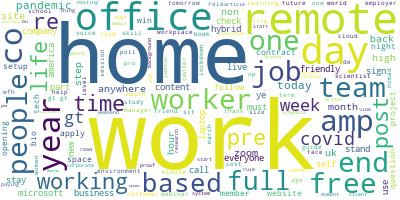

In [24]:
from wordcloud import WordCloud

unique_tweets = tweets_df['text_processed']

# join the words of the different tweets together into one string
long_string = ' '.join(unique_tweets)
new_long_string = ' '.join(set(long_string.split(" ")))

# create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# generate a word cloud
wordcloud.generate(new_long_string)

# visualize the word cloud
wordcloud.to_image()

In [25]:
def generate_word_cloud(processed_tweet_list: list, max_words=500):
  # join the words of the different tweets together into one string
  long_string = ' '.join(processed_tweet_list)
  new_long_string = ' '.join(set(long_string.split(" ")))

  # create a WordCloud object
  wordcloud = WordCloud(background_color="white", max_words=max_words, contour_width=3, contour_color='steelblue')

  # generate a word cloud
  wordcloud.generate(new_long_string)

  # visualize the word cloud
  return wordcloud.to_image()

# Topic Modelling

In [26]:
!pip install -U gensim

Requirement already up-to-date: gensim in /usr/local/lib/python3.7/dist-packages (4.0.1)


In [27]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:513: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/usr/l

In [28]:
#NLTK stop words
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

/usr/local/lib/python3.7/dist-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/usr/local/lib/python3.7/dist-packages/scipy/io/matlab/mio5.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. D

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
# Do you want to modify this by adding more stop words?
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [30]:
# Tokenize words and Clean-up textn-up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = tweets_df.text_processed.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1])

[['now', 'do', 'florida', 'then', 'ask', 'yourselves', 'who', 'handled', 'covid', 'better']]


Remove Stopwords and Lemmatize

The advantage of Lemmatization is that it can reduce the total number of unique words in the dictionary.The ultimate goal of lemmatization is to help the LDA model to produce better topics in the end.

In [31]:
spacy.load("en_core_web_trf")

In [32]:
# Define functions for stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

#Define functions for Lemmatization
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    nlp = spacy.load("en_core_web_trf", disable=["parser", "ner"])
    texts_out = [ ]
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Do lemmatization, keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

Create the Dictionary and Corpus needed for Topic Modeling

In [33]:
# create a dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# convert the corpus into a BoW representation
corpus = [id2word.doc2bow(text) for text in texts]

In [34]:
#use model perplexity and topic coherence to decide the number of topics.
model_list = []
perplexity = []
coherence_values = []

for num_topics in range(2,21,1):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                               id2word=id2word,
                               random_state=1,
                               num_topics=num_topics)
    model_list.append(lda_model)
    
#Calculate perplexity
    perplexity_values = lda_model.log_perplexity(corpus)
    print('Perplexity of %d topics is: ' % (num_topics-1), perplexity_values) # a measure of how good the model is. lower the better.
    perplexity.append(perplexity_values)

#Calculate coherence
    coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_values.append(round(coherencemodel.get_coherence(),3))
    print('The Coherence of %d topics is: ' % (num_topics-1), round(coherencemodel.get_coherence(),3))


Perplexity of 1 topics is:  -7.371156571869331
The Coherence of 1 topics is:  0.155
Perplexity of 2 topics is:  -7.46040492443509
The Coherence of 2 topics is:  0.153
Perplexity of 3 topics is:  -7.529779400407094
The Coherence of 3 topics is:  0.175
Perplexity of 4 topics is:  -7.585774079476704
The Coherence of 4 topics is:  0.26
Perplexity of 5 topics is:  -7.636958472401299
The Coherence of 5 topics is:  0.268
Perplexity of 6 topics is:  -7.710340935239578
The Coherence of 6 topics is:  0.307
Perplexity of 7 topics is:  -7.803170619017558
The Coherence of 7 topics is:  0.286
Perplexity of 8 topics is:  -7.9450966371230365
The Coherence of 8 topics is:  0.311
Perplexity of 9 topics is:  -8.134914218025763
The Coherence of 9 topics is:  0.341
Perplexity of 10 topics is:  -8.367586916029959
The Coherence of 10 topics is:  0.3
Perplexity of 11 topics is:  -8.629635991769574
The Coherence of 11 topics is:  0.348
Perplexity of 12 topics is:  -8.85155999745333
The Coherence of 12 topics i

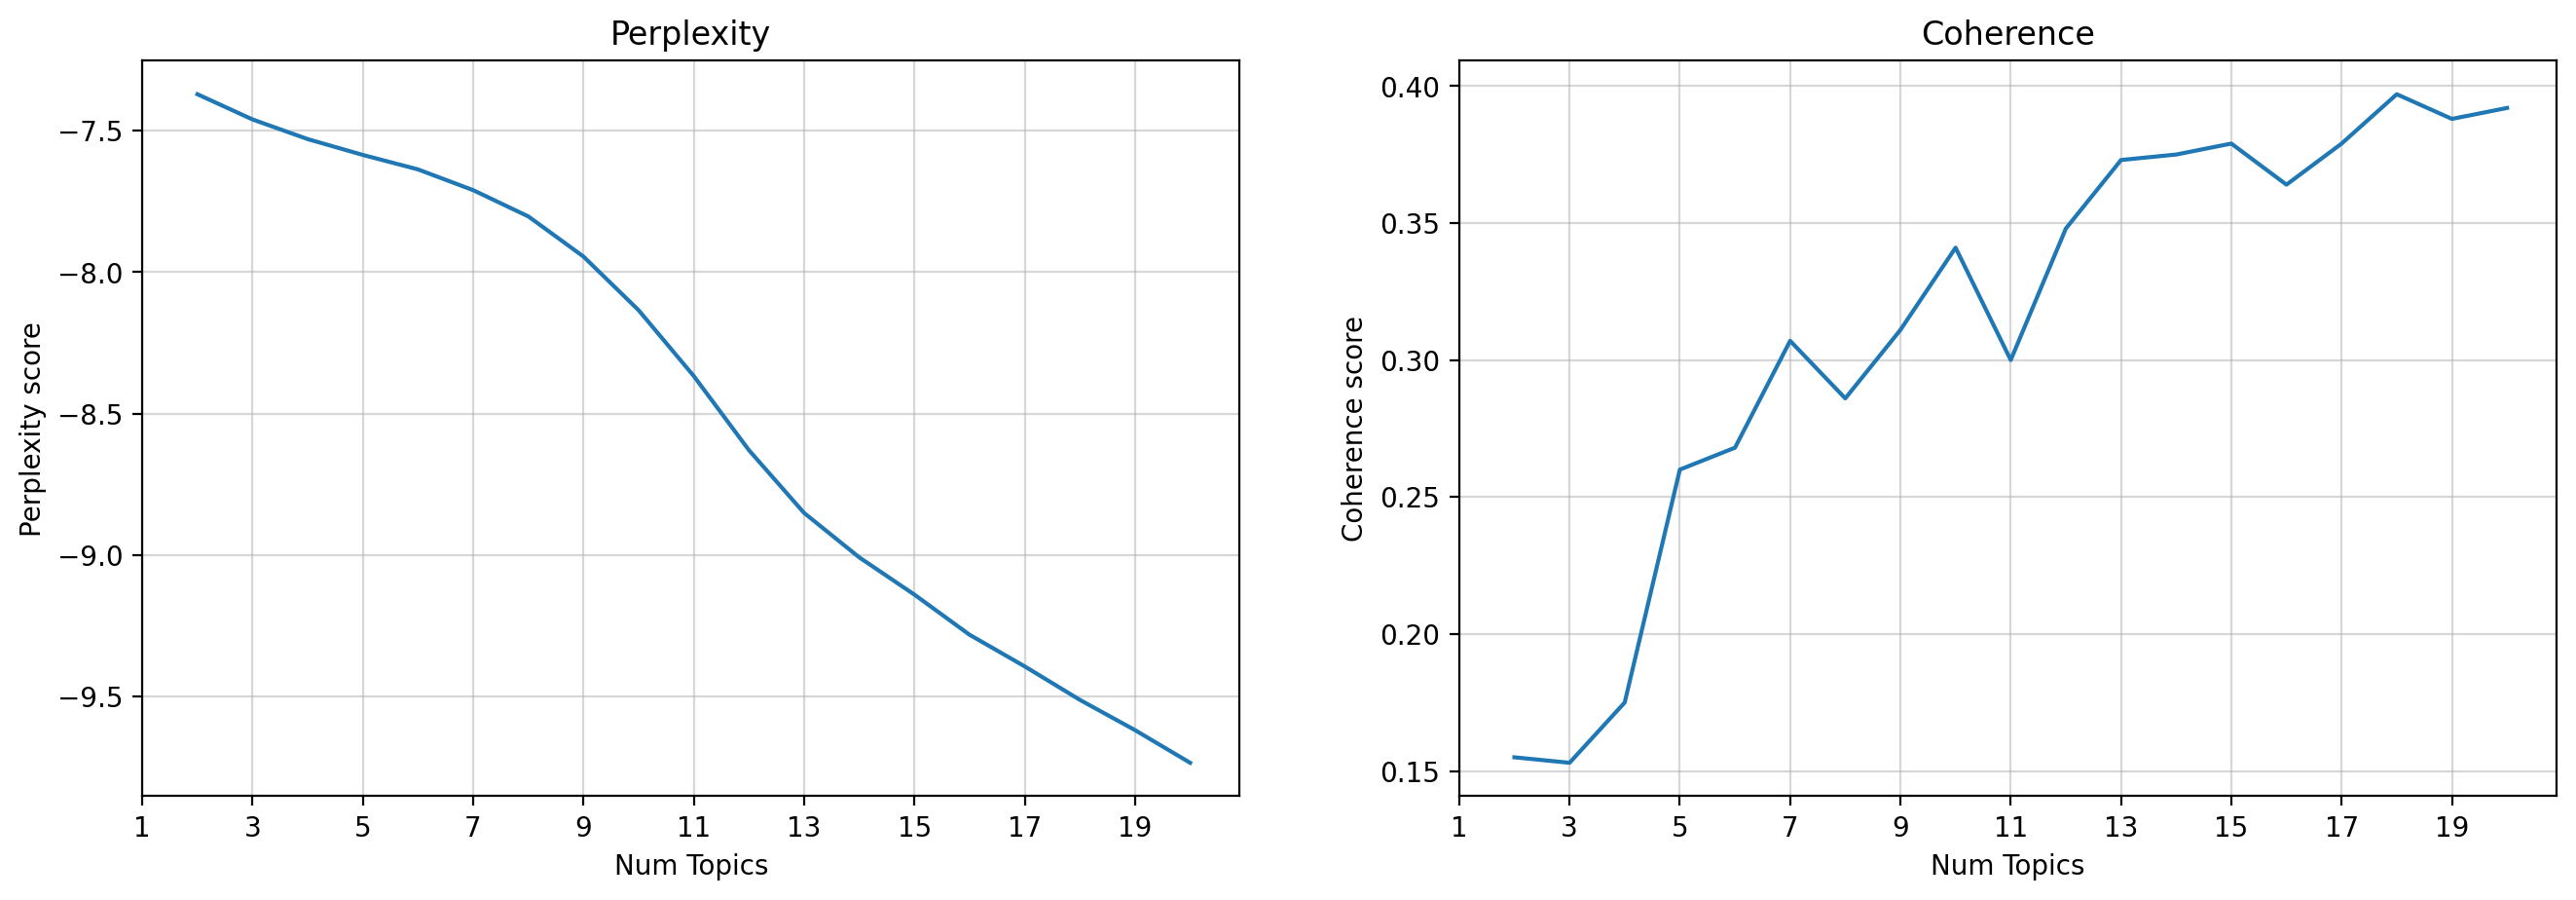

In [35]:
import matplotlib.pyplot as plt
#Draw Perplexity-Coherence-Topic line chart
#Use the subplot() method to draw multiple graphs
plt.figure(figsize=(16,5),dpi=200)
x = range(2,21,1)

#The drawing board is divided into blocks composed of 2 rows and 1 column, and the first area is obtained
ax1 = plt.subplot(1,2,1)
#Draw in the first subarea
plt.plot(x,perplexity)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.xticks(range(1,21,2))#Set the scale
plt.title('Perplexity')
plt.grid(True, alpha=0.5)

#Select the second sub-area and draw
ax2 = plt.subplot(1,2,2)
plt.plot(x,coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xticks(range(1,21,2))#Set the scale
plt.title('Coherence')
plt.grid(True, alpha=0.5)

plt.show()

In [36]:
# set number of topics
num_topics = 12

# build an LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

# print keywords in each topic
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.030*"work" + 0.022*"day" + 0.017*"year" + 0.015*"home" + 0.014*"new" + '
  '0.011*"last" + 0.009*"office" + 0.009*"remote" + 0.009*"time" + '
  '0.007*"amp"'),
 (1,
  '0.016*"office" + 0.012*"find" + 0.010*"team" + 0.010*"year" + 0.009*"home" '
  '+ 0.008*"see" + 0.008*"get" + 0.007*"many" + 0.007*"use" + 0.007*"work"'),
 (2,
  '0.090*"work" + 0.046*"home" + 0.021*"office" + 0.018*"remote" + 0.009*"day" '
  '+ 0.008*"say" + 0.008*"today" + 0.007*"staff" + 0.007*"job" + 0.007*"get"'),
 (3,
  '0.024*"work" + 0.015*"home" + 0.013*"office" + 0.013*"time" + 0.013*"make" '
  '+ 0.009*"get" + 0.008*"company" + 0.007*"business" + 0.007*"remote" + '
  '0.006*"last"'),
 (4,
  '0.042*"work" + 0.035*"home" + 0.018*"need" + 0.018*"office" + 0.015*"new" + '
  '0.010*"make" + 0.009*"tip" + 0.009*"year" + 0.008*"month" + 0.008*"person"'),
 (5,
  '0.044*"work" + 0.028*"home" + 0.017*"today" + 0.015*"new" + 0.013*"remote" '
  '+ 0.010*"price" + 0.010*"amp" + 0.009*"year" + 0.007*"start" + '
  

In [ ]:
# visualise the topics
!pip install pyLDAvis

In [42]:
import os
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./'+str(num_topics))

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
with open(LDAvis_data_filepath, 'wb') as f:
  pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, 'rb') as f:
  LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './'+ str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.060360  0.028548       1        1  14.953139
8     -0.067447  0.007129       2        1  12.059445
4     -0.040243  0.054551       3        1  11.125552
5     -0.039638 -0.003664       4        1   9.346798
6     -0.010515  0.046708       5        1   8.304734
7     -0.036951  0.001649       6        1   8.138826
0      0.001430 -0.081593       7        1   7.366615
10    -0.017210  0.042346       8        1   7.111363
3     -0.032146 -0.040760       9        1   7.069588
9      0.040120 -0.112703      10        1   5.318942
1      0.121154 -0.032368      11        1   4.879105
11     0.141806  0.090155      12        1   4.325892, topic_info=            Term        Freq        Total Category  logprob  loglift
125          get  264.000000   264.000000  Default  30.0000  30.0000
47           day  268.000000   268.000000  Default  29.0000  29.0000
27        remote  435.000000   435.000000  Default  28.0000  28.0000
45          year  254.000000   254.000000  Default  27.0000  27.0000
62          find  124.000000   124.000000  Default  26.0000  26.0000
..           ...         ...          ...      ...      ...      ...
49          home    7.858688  1062.451792  Topic12  -5.3621  -1.7662
168          job    6.519644   144.808673  Topic12  -5.5489   0.0400
107  opportunity    5.765989    38.514457  Topic12  -5.6718   1.2415
152       office    6.407781   464.528222  Topic12  -5.5662  -1.1430
115         week    6.009633   122.909006  Topic12  -5.6304   0.1225

[937 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
5132      3  0.858886        abou
2812      2  0.686259    absolute
5127      8  0.889926   accessory
5302     10  0.605090  acclimated
1012      1  0.186961    actually
...     ...       ...         ...
45        9  0.023542        year
45       10  0.027466        year
45       11  0.070627        year
45       12  0.043161        year
5264      3  0.858958  yesterdayi

[2389 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 5, 6, 7, 8, 1, 11, 4, 10, 2, 12])

# Sentiment Analysis

## Polarised text analysis

In [ ]:
# TextBlob sentiment analysis
!pip install TextBlob
from textblob import TextBlob

In [44]:
# store the analysed tweets into these categories
negative_tweets = []
positive_tweets = []
neutral_tweets = []

# configure the thresholds
subj_threshold = 0.5
polt_threshold = 0.5
neut_threshold = 0.1

# loop through all processed tweets and put them into
# positive, negative or neutral category
for tweet_text, tweet_id in zip(tweets_df['text_processed'], tweets_df['id']):
  blob = TextBlob(tweet_text)
  if blob.sentiment.subjectivity >= subj_threshold:
    if blob.sentiment.polarity >= polt_threshold:
      positive_tweets.append({'id': tweet_id, 'text_processed': tweet_text, 'sentiment': blob.sentiment})
    elif blob.sentiment.polarity <= (-1 * polt_threshold):
      negative_tweets.append({'id': tweet_id, 'text_processed': tweet_text, 'sentiment': blob.sentiment})
    elif blob.sentiment.polarity >= (-1 * neut_threshold) and blob.sentiment.polarity <= neut_threshold:
      neutral_tweets.append({'id': tweet_id, 'text_processed': tweet_text, 'sentiment': blob.sentiment})

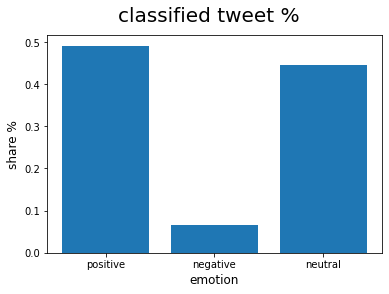

In [45]:
# calculate the total no. of tweets analysed
total_sentiment_tweets = len(positive_tweets) + len(negative_tweets) + len(neutral_tweets)

# % share of tweets categorised as postive, negative, neutral
fig = plt.figure()
plt.bar(['positive', 'negative', 'neutral'], [len(positive_tweets)/total_sentiment_tweets, len(negative_tweets)/total_sentiment_tweets, len(neutral_tweets)/total_sentiment_tweets])
fig.suptitle('classified tweet %', fontsize=20)
plt.xlabel('emotion', fontsize=12)
plt.ylabel('share %', fontsize=12)
plt.show()

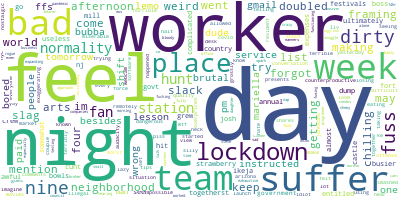

In [46]:
# word cloud for negative tweets
generate_word_cloud([tweet['text_processed'] for tweet in negative_tweets])

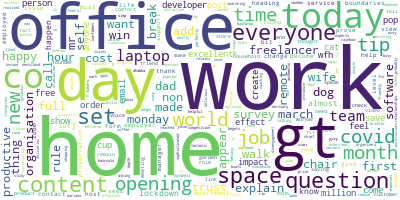

In [47]:
# word cloud for positive tweets
generate_word_cloud([tweet['text_processed'] for tweet in positive_tweets])

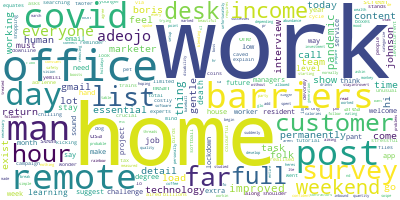

In [48]:
# word cloud for neutral tweets
generate_word_cloud([tweet['text_processed'] for tweet in neutral_tweets])

In [49]:
# experimentation to calculate choose the subjectivity
# and polarity threshold
# for each value in (+0.1) [0.1, 0.9] for thresholds, we categories
# tweets as positive and negative
threshold_ratio = []
for i in range(0, 10):
  subjectivity_threshold = i * 0.1
  polt = []
  for j in range(0, 10):
    pos_tweets = []
    neg_tweets = []
    polarity_threshold = j * 0.1
    for tweet_text, tweet_id in zip(tweets_df['text_processed'], tweets_df['id']):
      blob = TextBlob(tweet_text)
      if blob.sentiment.subjectivity > subjectivity_threshold:
        if blob.sentiment.polarity > polarity_threshold:
          pos_tweets.append({'id': tweet_id, 
                             'text_processed': tweet_text, 
                             'sentiment': blob.sentiment})
        elif blob.sentiment.polarity < (-1 * polarity_threshold):
          neg_tweets.append({'id': tweet_id, 
                            'text_processed': tweet_text, 
                            'sentiment': blob.sentiment})
    polt.append({"sub_t": subjectivity_threshold, 
                            "pol_t": polarity_threshold, 
                            "pos_tweets": pos_tweets,
                            "neg_tweets": neg_tweets})

  threshold_ratio.append(polt)


In [50]:
# calculate the ratio of no.of +ve tweets and no. of -ve tweets
# for each combination of subjectivity and polarity threshold
threshold_ratio_calculated = []

for subjs in threshold_ratio:
  calc_ratio = []
  for polt in subjs:
    count_pos = len(polt['pos_tweets'])
    count_neg = len(polt['neg_tweets'])
    if count_pos == 0:
      count_pos = 1
    if count_neg == 0:
      count_neg = 1
    pos_neg_ratio = count_pos / count_neg
    calc_ratio.append(pos_neg_ratio)
  threshold_ratio_calculated.append(calc_ratio)

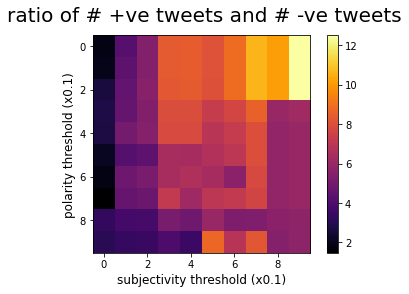

In [51]:
# plot the ratio of no.of +ve tweets and no. of -ve tweets
# for each combination of subjectivity and polarity threshold
fig = plt.figure()
plt.imshow(threshold_ratio_calculated, cmap='inferno', interpolation='nearest')
fig.suptitle('ratio of # +ve tweets and # -ve tweets', fontsize=20)
plt.xlabel('subjectivity threshold (x0.1)', fontsize=12)
plt.ylabel('polarity threshold (x0.1)', fontsize=12)
plt.colorbar()
plt.show()

## Emoji Analysis

In [52]:
!pip install emoji
import emoji

In [53]:
# function to load emojis from file
def load_emoji(filename: str):
  found = []
  with open(filename, 'r') as fp:
    line = fp.readline()
    while line:
      emoji_found = ''.join(c for c in line if c in emoji.UNICODE_EMOJI['en'])
      found.append(f'{emoji_found[0]}')
      line = fp.readline()
  return found

In [54]:
# load each emoji file
pos_emoji = load_emoji('emojis/face_positive.txt')
neg_emoji = load_emoji('emojis/face_negative.txt')
neut_emoji = load_emoji('emojis/face_neutral.txt')

In [55]:
# get frequency of each unique emoji ub
# in all the tweets
emoji_dict = {}
# trying to look for emojis
for x in tweets_df['text']:
  emoji_found = ''.join(c for c in x if c in emoji.UNICODE_EMOJI['en'])
  if len(emoji_found) > 0:
    for emo in emoji_found:
      if emo in emoji_dict:
        emoji_dict[emo] += 1
      else:
        emoji_dict[emo] = 1

In [56]:
# store count of each of the classifed emoji
# emoji can be positive, negative, neutral
emoji_analysis = {
  'pos': {'count': 0, 'found': []},
  'neg': {'count': 0, 'found': []},
  'neut': {'count': 0, 'found': []},
}

# populate the analused emoji count
for emo in pos_emoji:
  if emo in emoji_dict.keys():
    found_result = emoji_dict[emo]
    emoji_analysis['pos']['count'] += found_result
    emoji_analysis['pos']['found'].append((emo, found_result))

for emo in neg_emoji:
  if emo in emoji_dict.keys():
    found_result = emoji_dict[emo]
    emoji_analysis['neg']['count'] += found_result
    emoji_analysis['neg']['found'].append((emo, found_result))

for emo in neut_emoji:
  if emo in emoji_dict.keys():
    found_result = emoji_dict[emo]
    emoji_analysis['neut']['count'] += found_result
    emoji_analysis['neut']['found'].append((emo, found_result))

# sort to know which emojis occur the most in each category
emoji_analysis['pos']['found'] = sorted(emoji_analysis['pos']['found'], key=lambda tup: tup[1], reverse=True)
emoji_analysis['neg']['found'] = sorted(emoji_analysis['neg']['found'], key=lambda tup: tup[1], reverse=True)
emoji_analysis['neut']['found'] = sorted(emoji_analysis['neut']['found'], key=lambda tup: tup[1], reverse=True)

total_emojis_analysed = emoji_analysis['pos']['count'] + emoji_analysis['neg']['count'] + emoji_analysis['neut']['count']

In [57]:
# 5 most popular emojis in each category
print(f"positive: {[(emo[0], emo[1]/emoji_analysis['pos']['count']) for emo in emoji_analysis['pos']['found'][0:5]]}")
print(f"negative: {[(emo[0], emo[1]/emoji_analysis['neg']['count']) for emo in emoji_analysis['neg']['found'][0:5]]}")
print(f"neutral: {[(emo[0], emo[1]/emoji_analysis['neut']['count']) for emo in emoji_analysis['neut']['found'][0:5]]}")

positive: [('😂', 0.2631578947368421), ('😍', 0.1286549707602339), ('🤣', 0.07602339181286549), ('😎', 0.05263157894736842), ('😅', 0.04093567251461988)]
negative: [('😭', 0.12), ('💀', 0.09333333333333334), ('😩', 0.08), ('🤤', 0.05333333333333334), ('😴', 0.05333333333333334)]
neutral: [('🤔', 0.2903225806451613), ('🙄', 0.16129032258064516), ('🧐', 0.0967741935483871), ('😐', 0.06451612903225806), ('😑', 0.06451612903225806)]


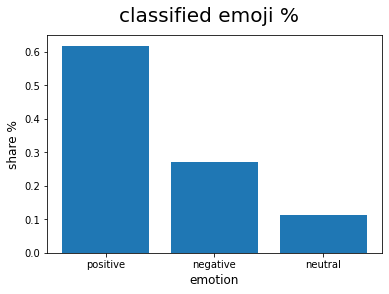

In [58]:
# % share of emojis categorised as postive, negative, neutral
fig = plt.figure()
plt.bar(['positive', 'negative', 'neutral'], [emoji_analysis['pos']['count']/total_emojis_analysed, emoji_analysis['neg']['count']/total_emojis_analysed, emoji_analysis['neut']['count']/total_emojis_analysed])
fig.suptitle('classified emoji %', fontsize=20)
plt.xlabel('emotion', fontsize=12)
plt.ylabel('share %', fontsize=12)
plt.show()

# Named Entity Recognition


This implementation is based on [spaCy's model](https://spacy.io/models/en#en_core_web_trf) using contextualised embeddings.

In [59]:
# comment if not using pre saved data set 
tweets_df = pd.read_csv('combined_platform.csv', quotechar='"', encoding='utf8')
cleaned_tweets = []

# include hastags and remove urls and emojis and mentions
#p.set_options(p.OPT.URL, p.OPT.EMOJI,p.OPT.MENTION)
for tweet in tweets_df['text']:
    cleaned_tweets.append(p.clean(tweet))

# adding back to data frame
tweets_df['text_processed'] = cleaned_tweets

#removing punctuation
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[,\\.!?]', '', x))

# Remove unnecessary line breaks
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r"\n", '', x))

#removing hastags for now 
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r"#(\w+)","",x))

#removing extra whitespaces 
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: ' '.join(x.split()))

tweets_df['text_processed_named'] = tweets_df['text_processed']

# Convert the titles to lowercase
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: x.lower())

display(tweets_df)

,id,date,user,location,text,text_processed,text_processed_named
0,1376741371684352007,2021-03-30 03:41:36,BillFOXLA,"Los Angeles, CA",This is now the 4th extremely graphic &amp; vi...,this is now the th extremely graphic &amp; vic...,This is now the th extremely graphic &amp; vic...
1,1376692197748305921,2021-03-30 00:26:12,jdawsey1,"202, 212, 843",I think this is one of the funniest SNL skits ...,i think this is one of the funniest snl skits ...,I think this is one of the funniest SNL skits ...
2,1376942126303428609,2021-03-30 16:59:19,jenheemstra,"Atlanta, GA she/her","Nothing says ""working from home"" quite like ""h...","nothing says ""working from home"" quite like ""h...","Nothing says ""working from home"" quite like ""h..."
3,1377074416236961795,2021-03-31 01:45:00,bookmansmesa,"Mesa, AZ",Have you heard the news? If you love #Anime an...,have you heard the news if you love and but do...,Have you heard the news If you love and but do...
4,1377072302957985792,2021-03-31 01:36:36,cocoajolie_,"Queens, NY",@Chi_TownBeauty 🤣🤣🤣🤣 when I’m on the phone it’...,when im on the phone its in even worse &amp; t...,when Im on the phone its in even worse &amp; t...
...,...,...,...,...,...,...,...
2974,1374563130630668291,2021-03-24 03:26:03,NoungahTV,Canada,"a place to call home and grow to this point, y...",a place to call home and grow to this point yo...,a place to call home and grow to this point yo...
2975,1374500281350639625,2021-03-23 23:16:18,Vet7Disgruntled,East coast,"I get home from work around 11pm est, who’s wa...",i get home from work around pm est whos wantin...,I get home from work around pm est whos wantin...
2976,1374499373153878016,2021-03-23 23:12:42,Mirandjamz,"Ottawa, Ontario",@Discordapp @discord ): Why are you down when ...,): why are you down when i'm finally home from...,): Why are you down when I'm finally home from...
2977,1374419061027696642,2021-03-23 17:53:34,iAMSiiiN,"Tampa, FL",SOME BANNER WORK FOR A CLIENT || !discord !sub...,some banner work for a client || discord sub,SOME BANNER WORK FOR A CLIENT || discord sub


In [60]:
!pip install spacy-transformers
!python -m spacy download en_core_web_trf

2021-04-01 16:48:15.541159: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


In [61]:
import spacy
import en_core_web_trf

nlp = spacy.load('en_core_web_trf')
unique_tweets = tweets_df['text_processed_named']

In [62]:
entity_list = []
for tweet_text in unique_tweets:
  doc = nlp(tweet_text)
  for ne in doc.ents:
    entity_list.append([ne.label_, tweet_text[ne.start_char:ne.end_char]])
 

entity_frequency = {}
type_frequency = {}
for i in range(0, len(entity_list)):
    if entity_list[i][1] in entity_frequency:
        entity_frequency[entity_list[i][1]][0] += 1
    else:
        entity_frequency[entity_list[i][1]] = [1, entity_list[i][0]]
    if entity_list[i][0] in type_frequency:
        type_frequency[entity_list[i][0]] += 1
    else:
        type_frequency[entity_list[i][0]] = 1

most_common_types = pd.DataFrame(type_frequency.items(), columns=['type', 'occurences'])
most_common_types = most_common_types.sort_values('occurences', ascending=False, ignore_index=True)
display(most_common_types[:30])

most_common_entities = pd.DataFrame(entity_frequency.items(), columns=['entity', 'occurences'])
most_common_entities[['occurences','type']] = pd.DataFrame(most_common_entities.occurences.tolist(),
                                                           index=most_common_entities.index)
most_common_entities = most_common_entities.sort_values('occurences', ascending=False, ignore_index=True)
display(most_common_entities[:30])

#most important types
relevant_types = ['PERSON', 'ORG', 'NORP', 'EVENT', 'PRODUCT', 'GPE']

relevant_entities = most_common_entities[(most_common_entities['type'].isin(relevant_types))]
display(relevant_entities[:30])

,type,occurences
0,ORG,838
1,DATE,338
2,PERSON,213
3,GPE,156
4,PRODUCT,130
5,TIME,100
6,CARDINAL,75
7,ORDINAL,62
8,WORK_OF_ART,51
9,MONEY,43


,entity,occurences,type
0,Microsoft,470,ORG
1,first,44,ORDINAL
2,Slack,37,ORG
3,VA,33,GPE
4,one,25,CARDINAL
5,Zoom,16,ORG
6,March,15,DATE
7,Teams,15,PRODUCT
8,today,14,DATE
9,tonight,13,TIME


,entity,occurences,type
0,Microsoft,470,ORG
2,Slack,37,ORG
3,VA,33,GPE
5,Zoom,16,ORG
7,Teams,15,PRODUCT
11,Discord,13,PRODUCT
12,Microsoft Teams,13,PRODUCT
15,US,11,GPE
16,Trueblue,10,ORG
18,Redmond,10,GPE


# Named Entity Linking

This implementation is based on [spaCy Entity Linker](https://github.com/egerber/spacy-entity-linker).

In [63]:
!pip install spacy-entity-linker
!python -m spacyEntityLinker "download_knowledge_base"

2021-04-01 16:57:07.660614: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [64]:
from spacyEntityLinker import EntityLinker
from spacy.language import Language

@Language.factory(
   "entityLinker"
)
def create_linker(nlp, name):
  return EntityLinker()

#add to pipeline
nlp.add_pipe('entityLinker')

In [65]:
linked_entities = []
for tweet_text in unique_tweets:
    doc = nlp(tweet_text)
    all_linked_entities = doc._.linkedEntities

    #all_linked_entities.pretty_print()
    for i in range(0,len(all_linked_entities)):
        linked_entities.append([all_linked_entities[i].get_label(), 
                                "https://www.wikidata.org/wiki/Q" + str(all_linked_entities[i].get_id())])

linked_frequency = {}

for i in range(0, len(linked_entities)):
    if linked_entities[i][0] in linked_frequency:
        linked_frequency[linked_entities[i][0]][0] += 1
    else:
        linked_frequency[linked_entities[i][0]] = [1, linked_entities[i][1]]
    
most_common_entities = pd.DataFrame(linked_frequency.items(), columns=['entity', 'occurences'])
most_common_entities[['occurences','url']] = pd.DataFrame(most_common_entities.occurences.tolist(),
                                                           index=most_common_entities.index)
most_common_entities = most_common_entities.sort_values('occurences', ascending=False, ignore_index=True)
display(most_common_entities[:30])

platform = ['Microsoft', "Zoom Video Communications", "Slack", "Discord", "Skype", "Outlook.com", "Microsoft Teams"]
platform_entities = most_common_entities[(most_common_entities['entity'].isin(platform))]
display(platform_entities[:30])

,entity,occurences,url
0,home,643,https://www.wikidata.org/wiki/Q7743
1,Microsoft,502,https://www.wikidata.org/wiki/Q2283
2,work,339,https://www.wikidata.org/wiki/Q42213
3,Zoom Video Communications,274,https://www.wikidata.org/wiki/Q17460900
4,workforce,110,https://www.wikidata.org/wiki/Q13440398
5,Workers,108,https://www.wikidata.org/wiki/Q8034770
6,human,108,https://www.wikidata.org/wiki/Q5
7,year,100,https://www.wikidata.org/wiki/Q577
8,Discord,95,https://www.wikidata.org/wiki/Q22907849
9,Slack,95,https://www.wikidata.org/wiki/Q17130715


,entity,occurences,url
1,Microsoft,502,https://www.wikidata.org/wiki/Q2283
3,Zoom Video Communications,274,https://www.wikidata.org/wiki/Q17460900
8,Discord,95,https://www.wikidata.org/wiki/Q22907849
9,Slack,95,https://www.wikidata.org/wiki/Q17130715
29,Microsoft Teams,42,https://www.wikidata.org/wiki/Q28406404
71,Skype,20,https://www.wikidata.org/wiki/Q40984
715,Outlook.com,2,https://www.wikidata.org/wiki/Q219136
